In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [8]:
N_EPOCH=5
ATTRS = True

In [3]:
import sys
sys.path.append("..")

from lib.generators.AttributedNetwork import AttributedNetwork


generator = AttributedNetwork(
    '../data/',
    'citeseer',
    features_to_normalize=['RAI', 'JC', 'AAI', 'PA'],
    with_attributes=ATTRS,
    seed=seed,
    vebrose=True
)

feature_names = generator.t_feature_names

INFO: Verbose output.
INFO: Reading data ...
INFO: Success!
INFO: Train/test splitting the data...
INFO: Success!
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features


In [4]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

link_prediction_train.dropna(inplace=True)
link_prediction_test.dropna(inplace=True)
classifier_test.dropna(inplace=True)

In [5]:
link_prediction_train.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA
0,1131,2027,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000530
1,3487,3930,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000000
2,1424,1585,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000265
3,1293,2740,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000000
4,565,3290,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001855


## Step 2
### Link prediction model

In [6]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


from keras import Input
from keras import layers as l
from keras.models import Model

from tensorflow.keras.utils import plot_model


def model(feature_names, attr_dim, attrs=True, embed_dim=4, hidden_dim=64):
    """
    A simple DL model for classification
    """

    # inputs to topological features
    feature_input = Input(shape=(len(feature_names), ), name='Topological features input')

    # node_attributes inputs
    attr_input_1 = Input(shape=(attr_dim, ), name='Node 1 attributes') if attr_dim > 0 else None
    attr_input_2 = Input(shape=(attr_dim, ), name='Node 2 attributes') if attr_dim > 0 else None

    # dynamic representation the attributes
    c = l.Concatenate()([attr_input_1, attr_input_2])
    attrs_dyn = l.Dense(embed_dim, activation='relu', name='Dynamic representation of the the attributes')(c)

    concat = l.Concatenate()([feature_input, attrs_dyn])

    if attrs:
        hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 1')(concat)
    else:
        hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 1')(feature_input)
        
    hidden = l.Dense(hidden_dim, activation='relu', name='Hidden layer 2')(hidden)

    out = l.Dense(1, activation='sigmoid', name='output')(hidden)

    if attrs:
        model = Model([feature_input, attr_input_1, attr_input_2], out)
    else:
        model = Model(feature_input, out)

    model.compile(optimizer='adam', loss='poisson', metrics=['accuracy'])

    return model

Using plaidml.keras.backend backend.
DEBUG: Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [7]:
# function to rearange data for training

def data_arrange(df, feature_names, train=True, attrs=True, goal='goal'):
    x_features = df[feature_names].values

    x_attrs_1 = np.array([np.array(item) for item in df['node_1_attrs'].values])
    x_attrs_2 = np.array([np.array(item) for item in df['node_2_attrs'].values])

    y = df[goal].values if train else None

    if attrs:
        return [x_features, x_attrs_1, x_attrs_2], y
    else:
        return x_features, y

In [9]:
attr_dim = len(link_prediction_train.head(1)['node_1_attrs'].values[0])

link_prediction_model = model(feature_names, attr_dim, attrs=ATTRS)
link_prediction_model.summary()

INFO:plaidml:Opening device "opencl_amd_radeon_pro_5300m_compute_engine.0"
INFO: Opening device "opencl_amd_radeon_pro_5300m_compute_engine.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Node 1 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
Node 2 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1204)         0           Node 1 attributes[0][0]          
                                                                 Node 2 attributes[0][0]          
__________________________________________________________________________________________________
Topological features input (Inp (None, 4)            0                                            
__________

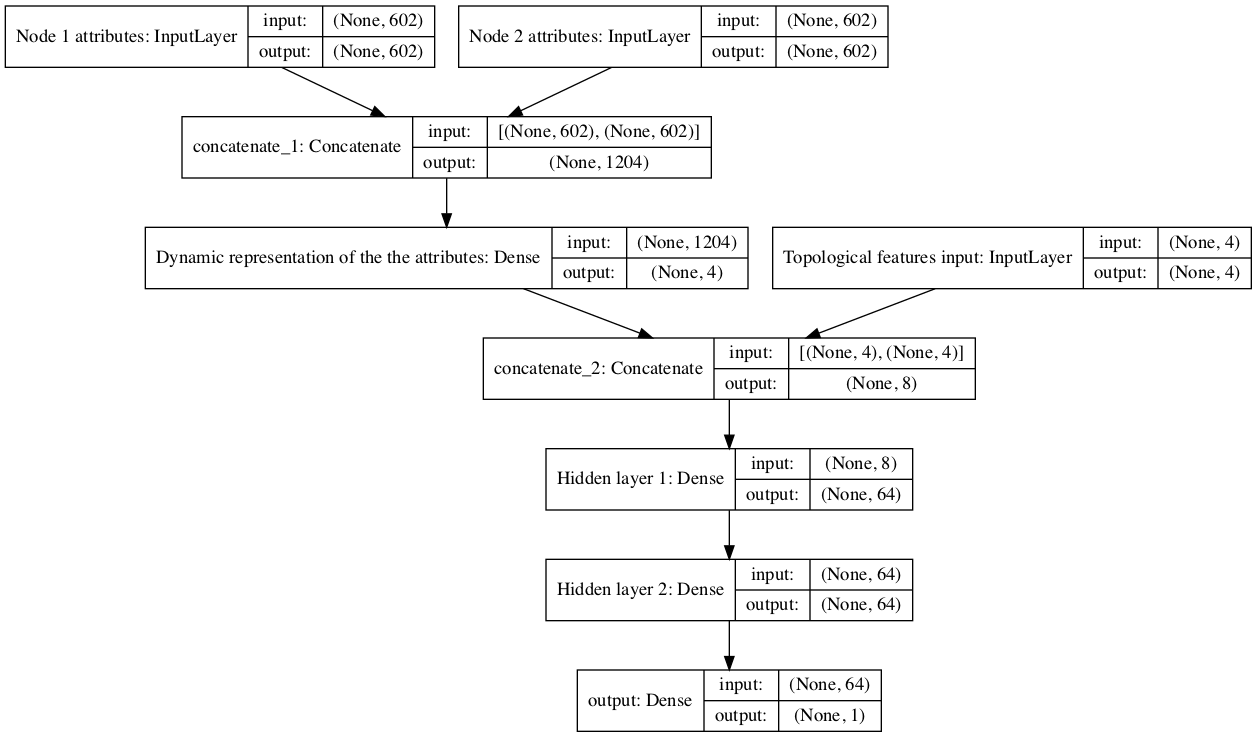

In [10]:
plot_model(link_prediction_model, show_shapes=True)

In [11]:
x, y = data_arrange(link_prediction_train, feature_names, attrs=ATTRS)
link_prediction_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
7496/7496 [==============================] - 5s 628us/step - loss: 0.8032 - acc: 0.6788
Epoch 2/5
7496/7496 [==============================] - 2s 220us/step - loss: 0.7287 - acc: 0.7956
Epoch 3/5
7496/7496 [==============================] - 2s 224us/step - loss: 0.6820 - acc: 0.8419
Epoch 4/5
7496/7496 [==============================] - 2s 218us/step - loss: 0.6493 - acc: 0.8650
Epoch 5/5
7496/7496 [==============================] - 2s 230us/step - loss: 0.6244 - acc: 0.8894


In [12]:
# predicting the links

x, _ = data_arrange(link_prediction_test, feature_names, train=False, attrs=ATTRS)

prob = link_prediction_model.predict(x).squeeze()
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob
0,794,3544,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000692,0.005953
1,2910,3875,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.070572
2,1529,3463,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.023944
3,2859,3208,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.016618
4,179,983,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.015918


In [13]:
from sklearn.metrics import roc_curve, auc


def plot_auc(df, x='goal', y='prob'):
    fig, ax = plt.subplots(1)

    fpr, tpr, _ = roc_curve(df[x], df[y])
    sn.lineplot(x=fpr, y=tpr, ax=ax)

    ax.legend([f'ROC curve, AUC = {auc(fpr, tpr):.4f}'])
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')


DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG: findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG: findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG: findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG: findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 40

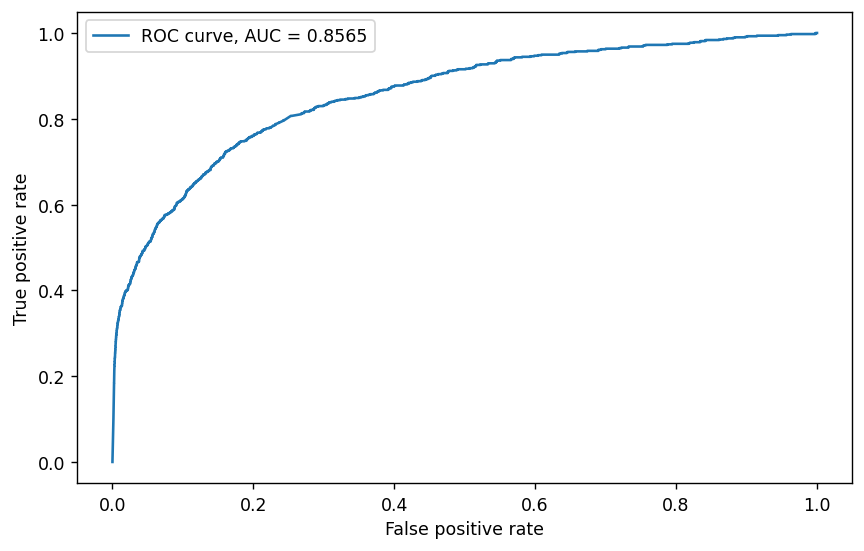

In [14]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125


# ROC-AUC for the link prediction model
plot_auc(link_proba, x='goal', y='prob')

## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [15]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error
0,794,3544,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000692,0.005953,0.005953
1,2910,3875,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.070572,0.070572
2,1529,3463,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.023944,0.023944
3,2859,3208,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.016618,0.016618
4,179,983,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.015918,0.015918


In [16]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.029211263172328472

In [17]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,794,3544,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000692,0.005953,0.005953,1
1,2910,3875,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.070572,0.070572,0
2,1529,3463,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.023944,0.023944,1
3,2859,3208,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.016618,0.016618,1
4,179,983,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000231,0.015918,0.015918,1


In [18]:
classification_model = model(feature_names, attr_dim, attrs=ATTRS)
classification_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Node 1 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
Node 2 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1204)         0           Node 1 attributes[0][0]          
                                                                 Node 2 attributes[0][0]          
__________________________________________________________________________________________________
Topological features input (Inp (None, 4)            0                                            
__________

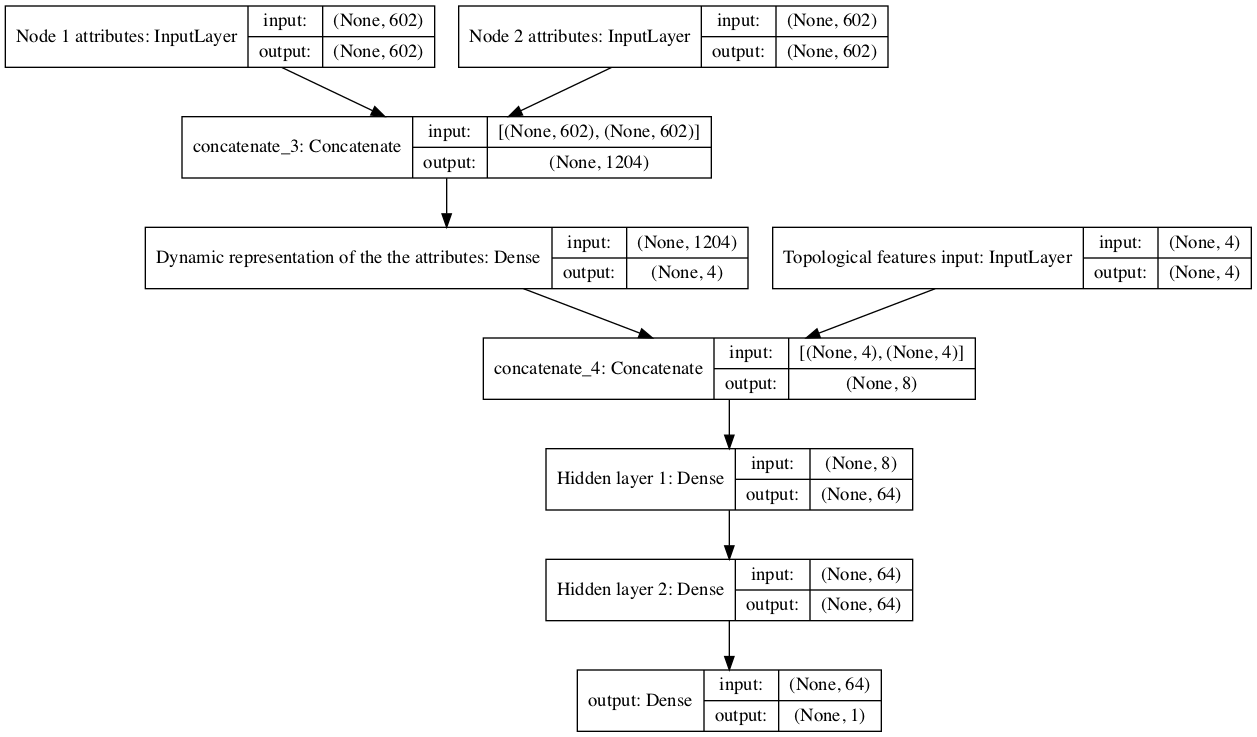

In [19]:
plot_model(classification_model, show_shapes=True)

In [20]:
x, y = data_arrange(link_proba, feature_names, goal='quality_label', attrs=ATTRS)

classification_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
1341650/1341650 [==============================] - 513s 383us/step - loss: 0.5775 - acc: 0.9320
Epoch 2/5
 107072/1341650 [=>............................] - ETA: 9:48 - loss: 0.5417 - acc: 0.9626

In [ ]:
# testing the classifier

T = 0.5

x, _ = data_arrange(classifier_test, feature_names, train=False, attrs=ATTRS)

quality_probability = classification_model.predict(x).squeeze()
link_probability = link_prediction_model.predict(x).squeeze()

quality_label = [1 if i > T else 0 for i in quality_probability]

classifier_test = classifier_test.join(pd.Series(quality_probability, name='predicted_quality_prob'))
classifier_test = classifier_test.join(pd.Series(link_probability, name='predicted_link_probability'))
classifier_test = classifier_test.join(pd.Series(quality_label, name='predicted_quality_label'))

In [ ]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['predicted_link_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.23907428979873657

In [ ]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,predicted_quality_prob,predicted_link_probability,predicted_quality_label,true_abs_error,true_quality_label
0,609,982,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001060,0.185615,0.026710,0,0.026710,1
1,1355,1747,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000795,0.073907,0.111812,0,0.111812,1
2,123,1149,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.002915,0.224314,0.766033,0,0.766033,0
3,160,3024,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001590,0.883515,0.004916,1,0.004916,1
4,825,2056,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.007156,0.170393,0.032308,0,0.032308,1


In [ ]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
0                     801
1                     801
dtype: int64

In [ ]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          877
0                          725
dtype: int64

In [ ]:
from sklearn import metrics

classifier_test.dropna(inplace=True)
y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    metrics.precision_score(y_true, y_pred),
    metrics.recall_score(y_true, y_pred),
    metrics.f1_score(y_true, y_pred)
])

scores_df

,Metric,Score
0,Sample length,1602.000000
1,Precision,0.576967
2,Recall,0.631710
3,F1 score,0.603099


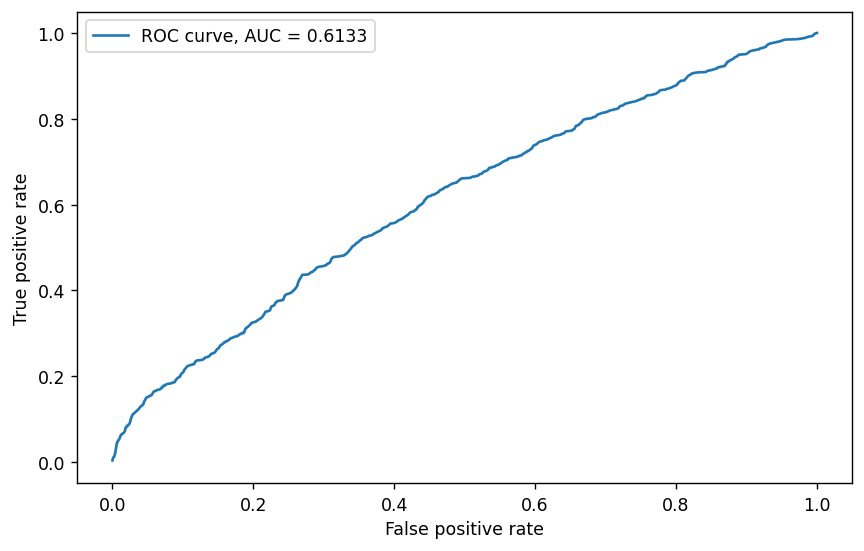

In [ ]:
plot_auc(classifier_test, 'true_quality_label', 'predicted_quality_prob')